# CENG 489 Data Mining
## Assignment 3 - Analysing a Toy Covid Data: Predict Clinical Cases and Association Rules
## Due: December 30 by 11:59pm

In [1]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Dataset Preparation

#### Loading Data

In [2]:
#read data from given xls ("COVID19 inpatient cases data.xls") (2nd sheet, not first sheet)
#look the first 5 records of data
df1 = pd.read_excel('COVID19 inpatient cases data.xls', sheet_name='data_reduced')
df1[:5]

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",NaN
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.0
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.0
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",NaN
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.0


In [3]:
# check column names, not null count and data types
# print(dataset.notnull().sum())

print(df1.dtypes)

Gender                                          object
Age                                              int64
Clinical classification                         object
Days from symptoms to hospital                   int64
No comorbidity                                  object
Cardiovascular and\ncerebrovascular disease     object
Endocrine system disease                        object
Malignant tumor                                 object
Respiratory system disease                      object
Digestive system disease                        object
Renal disease                                   object
Liver disease                                   object
Fever                                           object
Cough                                           object
Chest tightness                                 object
Fatigue                                         object
Diarrhea                                        object
Others                                          object
Clinical o

#### Dataset preprocessing 

##### Datasets for FIM and Rule extraction

In [4]:
symptom_cols = ['Fever', 'Cough','Chest tightness', 'Fatigue', 'Diarrhea', 'Others']
# create df_symtoms dataframe including given columns

df_symptoms = pd.DataFrame(data=df1[symptom_cols], columns = symptom_cols)


# add "Covid19" columns assign all entries as "Y"
df_symptoms = df_symptoms.assign(Covid19 = "Y")


In [5]:
disease_cols = ['Cardiovascular and\ncerebrovascular disease', 'Endocrine system disease','Malignant tumor','Respiratory system disease', 
                'Digestive system disease','Renal disease','Liver disease']
other_cols= ['Age','Gender']
# create df_diseases dataframe consisting records of given cols(disease_cols and other_cols) 
# from main dataframe
df_diseases = pd.DataFrame(data = df1[disease_cols+other_cols],columns = disease_cols+ other_cols)


# add also "Clinicial classification" attribute from main dataframe calling  
# this column as "Illness" in your df_diseases dataframe
df_diseases = df_diseases.assign(Illness = pd.Series(df1['Clinical classification']) )


# add " ill" string to all records in "illness" attribute 
df_diseases['Illness'] += " illness"
# df_diseases.head(10)


In [6]:
# categorize ages as "Elderly" (Age>=65), 
#                        "Adults" (18<= Age <65),
#                        "Teens" (12=<Age<18),
#                        "Children" (1<Age<12), 
#                        "Infants" (Age<=1)


# in new column "Age Group", drop "Age" column in df_disease dataframe.
split_ =pd.cut(df_diseases['Age'], bins=[   0,   1,         11,           17,     64,          150], 
                            labels= ['Infants', 'Children',    'Teens','Adults','Elderly'])

df_diseases['Age Group'] = split_

df_diseases.drop(["Age"] ,axis=1, inplace=True)
# df_diseases.head(20)

In [7]:
# Convert "Gender", "Illness", "Age Group" attributes to dummies for one-hot encoding, \
#  then drop these attributes from df_diseases
def encode_and_drop_attributes():
    target_attr = ['Gender', 'Illness', 'Age Group']
    dummies = pd.get_dummies(df_diseases[target_attr])
    new_df = pd.concat([df_diseases, dummies], axis=1)
    new_df = new_df.drop(target_attr, axis=1)
    return new_df

df_diseases = encode_and_drop_attributes()
# df_diseases

    
    

In [8]:
# convert all data to bool (True or False) (by replacing or mapping attribute values ) for df_symptoms dataframe

df_symptoms.replace({'Y':True, 'N':False}, inplace=True)
# df_symptoms


In [9]:
# same for df_diseases dataframe
df_diseases.replace({'Y':True, 'N':False}, inplace=True)
# df_diseases

In [10]:
# install mlxtend library (suggested version is 0.15.0.0)
import mlxtend

In [11]:
### create "df_symptoms_extended" concatanating df_symptoms with df_diseases 
# dummy attributes of "Gender", "Illness", "Age Group" and their records.
# drop "Covid19" attribute in extended dataframe

# df_symptoms_extended = pd.DataFrame

df_symptoms_extended = pd.concat([df_symptoms, df_diseases.iloc[:,7:]], axis=1)
df_symptoms_extended.drop("Covid19", axis=1, inplace=True)
# df_symptoms_extended


#### Fill mising values with KNN

The usage of KNNImputer is not allowed.

In [12]:
# show missing record as (number of missings/total) (should be only "Hospital stay, days") 
total_number = df1["Hospital stay, days"].shape[0]
missing = df1["Hospital stay, days"].isna().sum()
print("Number of missing/total values = ",missing,"/",total_number)


Number of missing/total values =  4 / 73


In [42]:
# copy dataframe df1 to df2 
df2 = df1.copy()
df2
# convert bools and strings to numeric attributes ('Male':1, 'Female':2, 'Heavy':1, 'Ordinary':2, 'Y':1, 'N':0)

df2.replace({'Y':1, 'N':0, 'Male':1, 'Female':2, 'Heavy':1, 'Ordinary':2}, inplace=True)
df2['Hospital stay, days'].min()
df2

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,0,47,1,15,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0,14.285714
1,1,53,2,13,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,6.000000
2,1,57,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,8.000000
3,0,58,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,16.857143
4,0,54,2,10,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1,30,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,24.000000
69,1,59,2,10,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,16.000000
70,1,87,2,10,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,14.000000
71,1,56,2,20,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,12.000000


In [14]:
def min_max_scale(df):

    val_ = df['Hospital stay, days']
    
    scaling = val_.sub(val_.min()).div((val_.max() - val_.min())) 
    print('val max=', df['Hospital stay, days'].max() , 'val min= ', val_.min())
    
    return scaling
    
def inv_min_max_scale(df, scaled_value):
    max_value = df1['Hospital stay, days'].max()
    min_value = df1['Hospital stay, days'].min()
    inv_value = (scaled_value*(max_value - min_value)) + min_value
    return inv_value
#     convert original range
min_max_scale(df2)

val max= 36.0 val min=  4.0


0         NaN
1     0.06250
2     0.12500
3         NaN
4     0.03125
       ...   
68    0.62500
69    0.37500
70    0.31250
71    0.25000
72    0.12500
Name: Hospital stay, days, Length: 73, dtype: float64

In [15]:
from sklearn import preprocessing
# min_max_scale for scaling missing atttribute (you will need for "nan" values)

df2['Hospital stay, days'] = min_max_scale(df2)

# # scale other nonmissing attributes using MinMaxScaler in sklearn

df2.replace({'Aggravated,turn to ICU':0, 'Improved and discharge':1,
       'Aggravated,transfer to superior hospital':2, 'Died':3}, inplace=True)


minmax_scale = preprocessing.MinMaxScaler().fit(df2.iloc[:,:19])
scaler_data = minmax_scale.transform(df2.iloc[:,:19])
columns_ = df2.columns

new_dataframe = pd.DataFrame(scaler_data, columns = columns_[:19])
new_dataframe = pd.concat([new_dataframe, df2['Hospital stay, days']], axis=1)



control = False


val max= 36.0 val min=  4.0


In [16]:
from sklearn.neighbors import KNeighborsRegressor

# finding null values 
null_index= new_dataframe['Hospital stay, days'].isnull()
a = new_dataframe['Hospital stay, days'].loc[null_index]
a = a.index           #nan values and it's index,
# create new dataframe for nan values 
nan_values = pd.DataFrame(columns=columns_) 
print(new_dataframe.iloc[3])
# split nan value for target value

if control == False:
    for i in a:
        nan_values = nan_values.append(new_dataframe.loc[i])
        new_dataframe = new_dataframe.drop([i])
    control = True


Gender                                         0.000000
Age                                            0.560606
Clinical classification                        0.000000
Days from symptoms to hospital                 0.000000
No comorbidity                                 0.000000
Cardiovascular and\ncerebrovascular disease    0.000000
Endocrine system disease                       1.000000
Malignant tumor                                0.000000
Respiratory system disease                     0.000000
Digestive system disease                       0.000000
Renal disease                                  0.000000
Liver disease                                  0.000000
Fever                                          0.000000
Cough                                          0.000000
Chest tightness                                0.000000
Fatigue                                        0.000000
Diarrhea                                       0.000000
Others                                         0

In [17]:
# fill missing values based on KNeighborsRegressor regression in sklearn (for k=7)
X_data = new_dataframe.iloc[:,:19]
y_data = new_dataframe.iloc[:,19]

neigh = KNeighborsRegressor(n_neighbors=7)

neigh.fit(X_data, y_data)

y_pred = neigh.predict(nan_values.iloc[:, :19])

k=0
for i in a:
    nan_values['Hospital stay, days'].loc[i] = y_pred[k]
    k+=1

    
new_dataframe = pd.concat([new_dataframe, nan_values], axis=0)
new_dataframe= new_dataframe.sort_index()
new_dataframe

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,0.0,0.393939,0.0,0.358974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.321429
1,1.0,0.484848,1.0,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.333333,0.062500
2,1.0,0.545455,1.0,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.125000
3,0.0,0.560606,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.401786
4,0.0,0.500000,1.0,0.230769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.333333,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.0,0.136364,1.0,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.625000
69,1.0,0.575758,1.0,0.230769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.333333,0.375000
70,1.0,1.000000,1.0,0.230769,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.312500
71,1.0,0.530303,1.0,0.487179,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.250000


In [18]:
# don't forget to convert original range
inv_trans = minmax_scale.inverse_transform(scaler_data)

for i in range(new_dataframe['Hospital stay, days'].count()):
    
    new_dataframe['Hospital stay, days'].iloc[i] = inv_min_max_scale(new_dataframe, new_dataframe['Hospital stay, days'].iloc[i])
        
        
Original_dataframe = pd.DataFrame(inv_trans, columns=columns_[:19])
                                  
Original_dataframe = pd.concat( [Original_dataframe, new_dataframe['Hospital stay, days']] , axis=1)



# fill df1 missings with given values
df1['Hospital stay, days'] = Original_dataframe['Hospital stay, days'] 



In [19]:
df1

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",14.285714
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.000000
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.000000
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",16.857143
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Female,30,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,24.000000
69,Female,59,Ordinary,10,N,N,Y,N,N,N,N,N,N,Y,N,Y,N,N,Improved and discharge,16.000000
70,Female,87,Ordinary,10,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Improved and discharge,14.000000
71,Female,56,Ordinary,20,N,Y,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,12.000000


#### Dataset for classification task

In [20]:
# copy df1 to data_df datafarme
data_df = df1 
data_df
# split data: 
# dependent data -> label attribute 'Clinical classification' as Y, 
# independent data -> features as X (including nonmissing features)
# convert attribute values to 0 and 1 ('Y':1, 'N':0, 'Male':0, "Female":1)


data_df.replace({'Y':1, 'N':0, 'Male':0, 'Female':1,
                'Aggravated,turn to ICU':0, 'Improved and discharge':1,
       'Aggravated,transfer to superior hospital':2, 'Died':3}, inplace=True)

X_data = data_df.iloc[:,:2]
X_data = pd.concat([X_data, data_df.iloc[:,3:]], axis=1)

y_data = data_df.iloc[:, 2]
y_data

0        Heavy
1     Ordinary
2     Ordinary
3        Heavy
4     Ordinary
        ...   
68    Ordinary
69    Ordinary
70    Ordinary
71    Ordinary
72    Ordinary
Name: Clinical classification, Length: 73, dtype: object

In [21]:
from sklearn.model_selection import train_test_split
# Split dataset as train and test set using sklearn (for random_state=44) 
# x_train, x_val, y_test, y_test = # to-do

x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, random_state=44)
x_train.shape

(54, 19)

### Apriori Part: Frequent Itemset Mining, Association Rule Extraction 

In [22]:
from mlxtend.frequent_patterns import apriori, association_rules

In [23]:
# find itemsets for df_symptoms data with min support=0.02 
# df_ap = # to-do

df_ap = apriori(df_symptoms, min_support=0.02)
df_ap

,support,itemsets
0,0.753425,(0)
1,0.753425,(1)
2,0.287671,(2)
3,0.136986,(3)
4,0.109589,(4)
...,...,...
66,0.027397,"(1, 3, 4, 6)"
67,0.027397,"(1, 3, 5, 6)"
68,0.054795,"(0, 1, 2, 3, 6)"
69,0.027397,"(0, 1, 3, 4, 6)"


In [24]:
# find itemsets for df_symptoms_extended data with min support=0.02 
# df_ap_extended = # to-do

df_ap_extended = apriori(df_symptoms_extended, min_support=0.02)

df_ap_extended.head(10)
# df_symptoms_extended

,support,itemsets
0,0.753425,(0)
1,0.753425,(1)
2,0.287671,(2)
3,0.136986,(3)
4,0.109589,(4)
5,0.136986,(5)
6,0.493151,(6)
7,0.506849,(7)
8,0.328767,(8)
9,0.671233,(9)


In [25]:
df_symptoms_extended

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Gender_Female,Gender_Male,Illness_Heavy illness,Illness_Ordinary illness,Age Group_Infants,Age Group_Children,Age Group_Teens,Age Group_Adults,Age Group_Elderly
0,True,True,True,True,True,False,0,1,1,0,0,0,0,1,0
1,True,True,True,False,False,False,1,0,0,1,0,0,0,1,0
2,True,True,False,False,False,False,1,0,0,1,0,0,0,1,0
3,False,False,False,False,False,False,0,1,1,0,0,0,0,1,0
4,True,True,True,False,False,False,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,True,False,False,False,False,1,0,0,1,0,0,0,1,0
69,False,True,False,True,False,False,1,0,0,1,0,0,0,1,0
70,False,True,False,False,False,False,1,0,0,1,0,0,0,0,1
71,True,True,False,False,False,False,1,0,0,1,0,0,0,1,0


In [26]:
# find itemsets for df_diseases data with min support=0.02 
# df_ap_diseases = # to-do

df_ap_diseases = apriori(df_diseases, min_support=0.02, use_colnames=True)
df_ap_diseases

,support,itemsets
0,0.273973,(Cardiovascular and\ncerebrovascular disease)
1,0.136986,(Endocrine system disease)
2,0.0547945,(Malignant tumor)
3,0.493151,(Gender_Female)
4,0.506849,(Gender_Male)
...,...,...
77,0.0684932,"(Illness_Ordinary illness, Age Group_Elderly, ..."
78,0.0547945,"(Age Group_Elderly, Illness_Heavy illness, End..."
79,0.0410959,"(Illness_Ordinary illness, Age Group_Adults, E..."
80,0.0273973,"(Age Group_Elderly, Illness_Heavy illness, Mal..."


In [27]:
# use mlxtend for generating association rules from symptoms itemset  (with min confidence =0.6)
# show rules with min support= 0.2
# rules0 = #to-do
frequent_items = apriori(df_symptoms, min_support=0.2)
rules0 = association_rules(frequent_items, metric="confidence", min_threshold=0.6,)
rules0

# Frequent if-then associations called association rules which consists of an antecedent 
# (if) and a consequent (then).


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0),(1),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
1,(1),(0),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
2,(2),(0),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041
3,(0),(6),0.753425,1.000000,0.753425,1.000000,1.000000,0.000000,inf
4,(6),(0),1.000000,0.753425,0.753425,0.753425,1.000000,0.000000,1.000000
5,(2),(1),0.287671,0.753425,0.246575,0.857143,1.137662,0.029837,1.726027
6,(1),(6),0.753425,1.000000,0.753425,1.000000,1.000000,0.000000,inf
7,(6),(1),1.000000,0.753425,0.753425,0.753425,1.000000,0.000000,1.000000
8,(2),(6),0.287671,1.000000,0.287671,1.000000,1.000000,0.000000,inf
9,"(0, 2)",(1),0.260274,0.753425,0.219178,0.842105,1.117703,0.023081,1.561644


In [28]:
# use mlxtend for generating association rules from extended symptoms itemset  (with min confidence =0.6)
# show rules with min support= 0.2
# rules1 = # to-do

frequent_items2 = apriori(df_symptoms_extended, min_support=0.2)
rules1 = association_rules(frequent_items2, metric="confidence", min_threshold=0.6,)
rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0),(1),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
1,(1),(0),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
2,(2),(0),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041
3,(6),(0),0.493151,0.753425,0.424658,0.861111,1.142929,0.053106,1.775342
4,(7),(0),0.506849,0.753425,0.328767,0.648649,0.860934,-0.053106,0.701791
...,...,...,...,...,...,...,...,...,...
78,"(0, 9, 6)",(13),0.232877,0.671233,0.232877,1.000000,1.489796,0.076562,inf
79,"(0, 13, 6)",(9),0.315068,0.671233,0.232877,0.739130,1.101154,0.021392,1.260274
80,"(9, 13, 6)",(0),0.260274,0.753425,0.232877,0.894737,1.187560,0.036780,2.342466
81,"(9, 6)","(0, 13)",0.301370,0.506849,0.232877,0.772727,1.524570,0.080128,2.169863


In [29]:
# use mlxtend for generating association rules from disease itemset  (with min confidence =0.6)
# show rules with min support= 0.1
# rules2 = # to-do

frequent_items3 = apriori(df_symptoms_extended, min_support=0.1)
rules2 = association_rules(frequent_items3, metric="confidence", min_threshold=0.6,)
rules2
# df_symptoms.iloc[:,6]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0),(1),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
1,(1),(0),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
2,(2),(0),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041
3,(3),(0),0.136986,0.753425,0.109589,0.800000,1.061818,0.006380,1.232877
4,(6),(0),0.493151,0.753425,0.424658,0.861111,1.142929,0.053106,1.775342
...,...,...,...,...,...,...,...,...,...
208,"(1, 13, 6)","(0, 9)",0.260274,0.452055,0.164384,0.631579,1.397129,0.046725,1.487280
209,"(9, 13, 6)","(0, 1)",0.260274,0.589041,0.164384,0.631579,1.072215,0.011071,1.115460
210,"(0, 1, 9, 7)",(13),0.164384,0.671233,0.109589,0.666667,0.993197,-0.000751,0.986301
211,"(0, 1, 13, 7)",(9),0.164384,0.671233,0.109589,0.666667,0.993197,-0.000751,0.986301


In [30]:
#find rules such as (...)-> (Covid19)    (min confidence= 0.6, min support = 0.2)
# from rules0
# a = rules0[rules0['consequents'].all == str(6)]
# a


In [31]:
# find rules such as (item1, item2)->(..) (length of antecedents is at least 2)(min confidence= 0.6, min support = 0.1)
# from rules1 and rules2

# rules1[  rules1['antecedents']>2]

In [32]:
# rules1
rules1['length'] = rules1['antecedents'].apply(lambda x:len(x))
rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
0,(0),(1),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137,1
1,(1),(0),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137,1
2,(2),(0),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041,1
3,(6),(0),0.493151,0.753425,0.424658,0.861111,1.142929,0.053106,1.775342,1
4,(7),(0),0.506849,0.753425,0.328767,0.648649,0.860934,-0.053106,0.701791,1
...,...,...,...,...,...,...,...,...,...,...
78,"(0, 9, 6)",(13),0.232877,0.671233,0.232877,1.000000,1.489796,0.076562,inf,3
79,"(0, 13, 6)",(9),0.315068,0.671233,0.232877,0.739130,1.101154,0.021392,1.260274,3
80,"(9, 13, 6)",(0),0.260274,0.753425,0.232877,0.894737,1.187560,0.036780,2.342466,3
81,"(9, 6)","(0, 13)",0.301370,0.506849,0.232877,0.772727,1.524570,0.080128,2.169863,2


In [33]:
# rules2
rules2['length'] = rules2['antecedents'].apply(lambda x:len(x))
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
0,(0),(1),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137,1
1,(1),(0),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137,1
2,(2),(0),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041,1
3,(3),(0),0.136986,0.753425,0.109589,0.800000,1.061818,0.006380,1.232877,1
4,(6),(0),0.493151,0.753425,0.424658,0.861111,1.142929,0.053106,1.775342,1
...,...,...,...,...,...,...,...,...,...,...
208,"(1, 13, 6)","(0, 9)",0.260274,0.452055,0.164384,0.631579,1.397129,0.046725,1.487280,3
209,"(9, 13, 6)","(0, 1)",0.260274,0.589041,0.164384,0.631579,1.072215,0.011071,1.115460,3
210,"(0, 1, 9, 7)",(13),0.164384,0.671233,0.109589,0.666667,0.993197,-0.000751,0.986301,4
211,"(0, 1, 13, 7)",(9),0.164384,0.671233,0.109589,0.666667,0.993197,-0.000751,0.986301,4


### Classification Part: Predicting Clinical Cases

#### Bayes Classifier

In [34]:
def confusion_matrix_create(prediction, y_test):
    confusion = pd.DataFrame([[0, 0 ],[0, 0 ],[0, 0 ]]
                                    ,columns = ['Ordinary', 'Heavy'] )
    
    confusion.set_axis(['Ordinary','Heavy','Totals'], axis=0, inplace=True)
    o_o, o_h, h_o, h_h = (0,0,0,0)

    for pred_, true_ in zip(prediction, y_test):
        if pred_ == "Ordinary":
            if true_ == pred_:
                o_o += 1
            else: 
                o_h +=1
        else:
            if true_ == "Ordinary":
                h_o += 1
            else:
                h_h += 1        
    confusion.iloc[0,0] = o_o
    confusion.iloc[0,1] = h_o
    confusion.iloc[1,0] = o_h
    confusion.iloc[1,1] = h_h

    confusion = confusion.assign(Totals = lambda x: confusion.iloc[:, 0] + confusion.iloc[:, 1])
    confusion.iloc[2,:] =(confusion.iloc[0,:] + confusion.iloc[1, :])
    confusion
    return confusion


def calculation_(prediction, y_test):

    print("\n**********************************************************************")
    print("FOR COMPARING WITH MY CALCULATION\nScikit-learn's accuracy : ", accuracy_score(prediction,y_test))
    print("\n**********************************************************************\n")

    #calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure (write these functions yourself (no additional libs))
    confusion_matrix = confusion_matrix_create(prediction, y_test)


    print("Confusion Matrix : \n", confusion_matrix)
    print("\n**********************************************************************")
    accuracy = (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,1]) / confusion_matrix.iloc[2,2]
    print(f"Accuracy : {accuracy}")
    print("\n**********************************************************************")
    error_ = (confusion_matrix.iloc[0,1]+ confusion_matrix.iloc[1,0]) / confusion_matrix.iloc[2,2]
    print(f"Error : {error_}")

    print("\n**********************************************************************")
    recall = (confusion_matrix.iloc[0,0] /  confusion_matrix.iloc[2,0]) 
    print(f"Recall : {recall}")

    print("\n**********************************************************************")
    precision = (confusion_matrix.iloc[0,0] /  confusion_matrix.iloc[0,2] )
    print(f"Precision : {precision}")

    print("\n**********************************************************************")
    sensitivity = (confusion_matrix.iloc[0,0] /  confusion_matrix.iloc[2,0] )
    print(f"Sensitivity : {sensitivity}")

    print("\n**********************************************************************")
    specifity = confusion_matrix.iloc[1,1] / confusion_matrix.iloc[1,2]
    print(f"Specifity : {specifity}")

    print("\n**********************************************************************")
    f1_measure = (2*precision*recall) / (precision+recall)
    print(f"F1 measure : {f1_measure}")
    print("\n**********************************************************************")
    return [accuracy,error_,recall,precision,sensitivity,specifity,f1_measure]

In [35]:
# Create a Multinomial Bayes Classifier
# Train the model using the training set
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

classifier_naivebayes = GaussianNB()
classifier_naivebayes.fit(x_train, y_train)

# Predict test set labels based on your model
prediction = classifier_naivebayes.predict(x_test)



naive_table_info = calculation_(prediction, y_test)


**********************************************************************
FOR COMPARING WITH MY CALCULATION
Scikit-learn's accuracy :  0.8421052631578947

**********************************************************************

Confusion Matrix : 
           Ordinary  Heavy  Totals
Ordinary        10      2      12
Heavy            1      6       7
Totals          11      8      19

**********************************************************************
Accuracy : 0.8421052631578947

**********************************************************************
Error : 0.15789473684210525

**********************************************************************
Recall : 0.9090909090909091

**********************************************************************
Precision : 0.8333333333333334

**********************************************************************
Sensitivity : 0.9090909090909091

**********************************************************************
Specifity : 0.8571428571428571

****

# Classification Part: Predicting Clinical Cases

In [36]:
# create ID3 Tree using sklearn
from sklearn.tree import DecisionTreeClassifier

decision_classifier = DecisionTreeClassifier(criterion="entropy")

# train Decision Tree Classifier
decision_classifier_ = decision_classifier.fit(x_train,y_train)


# Predict classes for test data
prediction_decision_classifier = decision_classifier_.predict(x_test)

# calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure, confusion matrix 
#           based on your defined functions

decision_table_info = calculation_(prediction_decision_classifier, y_test)




**********************************************************************
FOR COMPARING WITH MY CALCULATION
Scikit-learn's accuracy :  0.6842105263157895

**********************************************************************

Confusion Matrix : 
           Ordinary  Heavy  Totals
Ordinary         9      3      12
Heavy            3      4       7
Totals          12      7      19

**********************************************************************
Accuracy : 0.6842105263157895

**********************************************************************
Error : 0.3157894736842105

**********************************************************************
Recall : 0.75

**********************************************************************
Precision : 0.75

**********************************************************************
Sensitivity : 0.75

**********************************************************************
Specifity : 0.5714285714285714

***********************************************

[Text(132.93529411764706, 203.85, 'X[1] <= 56.5\nentropy = 0.899\nsamples = 54\nvalue = [17, 37]'),
 Text(39.38823529411765, 176.67000000000002, 'X[2] <= 9.5\nentropy = 0.402\nsamples = 25\nvalue = [2, 23]'),
 Text(19.694117647058825, 149.49, 'entropy = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(59.082352941176474, 149.49, 'X[14] <= 0.5\nentropy = 0.684\nsamples = 11\nvalue = [2, 9]'),
 Text(39.38823529411765, 122.31, 'X[1] <= 49.0\nentropy = 0.469\nsamples = 10\nvalue = [1, 9]'),
 Text(19.694117647058825, 95.13, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(59.082352941176474, 95.13, 'X[1] <= 53.5\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(39.38823529411765, 67.94999999999999, 'X[18] <= 9.0\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(19.694117647058825, 40.77000000000001, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(59.082352941176474, 40.77000000000001, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(78.7764705882353, 67.94999999999999, 'entr

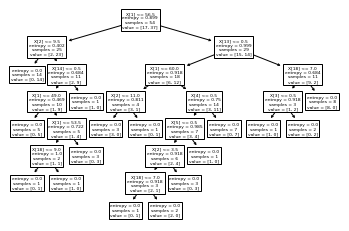

In [37]:
# visualize your tree using plot_tree inside sklearn (its version should be >= 0.21) and dtreeplt
# !pip install dtreeplt
from sklearn import tree
tree.plot_tree(decision_classifier)

#### KNN Classifier

In [38]:
# classify test data with KNN classifier of sklearn (for each possible k value)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt



def calculate_accuracy(k_neighbor):    
    classifier = KNeighborsClassifier(n_neighbors=k_neighbor)
    classifier.fit(x_train, y_train)
    y_pred2 = classifier.predict(x_test)

    
    
# calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure, confusion matrix  
#           based on your defined functions (using k=7)
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(x_train, y_train)
knn_prediction = classifier.predict(x_test)
knn_table_info = calculation_(knn_prediction, y_test)


# plot test errors for each k


**********************************************************************
FOR COMPARING WITH MY CALCULATION
Scikit-learn's accuracy :  0.6842105263157895

**********************************************************************

Confusion Matrix : 
           Ordinary  Heavy  Totals
Ordinary        10      2      12
Heavy            4      3       7
Totals          14      5      19

**********************************************************************
Accuracy : 0.6842105263157895

**********************************************************************
Error : 0.3157894736842105

**********************************************************************
Recall : 0.7142857142857143

**********************************************************************
Precision : 0.8333333333333334

**********************************************************************
Sensitivity : 0.7142857142857143

**********************************************************************
Specifity : 0.42857142857142855

****

### Evaluation Part: Decision Boundries, ROC Curves, Performance Comparisons

In [39]:
# show decision boundaries for each classifiers on same plot (show pairwise since we have more than 2 attiributes)
# Plotting decision regions

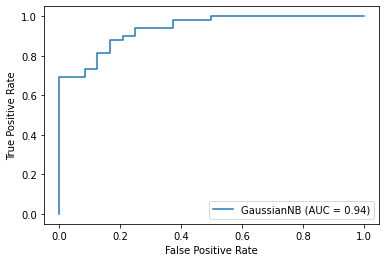

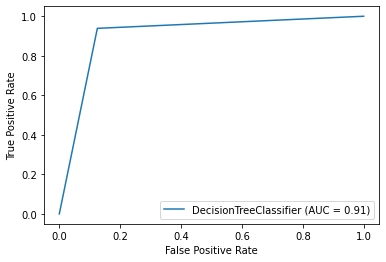

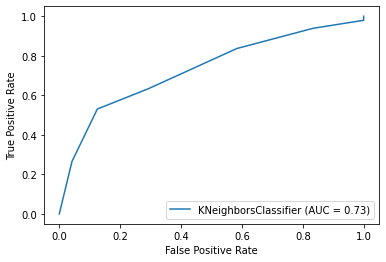

In [40]:
# draw ROC curves for each classifier
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection
metrics.plot_roc_curve(classifier_naivebayes, X_data, y_data)
plt.show()

metrics.plot_roc_curve(decision_classifier_, X_data, y_data)
plt.show()

metrics.plot_roc_curve(classifier, X_data, y_data)
plt.show()


In [41]:
# show classification results based on all measures (acc,err,recall, specifity, etc.) inside a table. 


results_df = pd.DataFrame([naive_table_info],
                          columns=['accuracy','error_','recall','precision','sensitivity',
                                   'specifity','f1_measure'])
results_df = pd.concat([results_df, pd.DataFrame([decision_table_info],
                                                
                          columns=['accuracy','error_','recall','precision','sensitivity',
                                   'specifity','f1_measure'])],axis=0, ignore_index=True )
results_df = pd.concat([results_df, pd.DataFrame([knn_table_info],
                                                
                          columns=['accuracy','error_','recall','precision','sensitivity',
                                   'specifity','f1_measure'])],axis=0, ignore_index=True )
# naive_table_info
# index_ = ["Naive", "Decision", "KNN"]
# results_df = results_df.reindex(index_)
results_df
# naive_table_info =decision_table_info knn_table_info 

,accuracy,error_,recall,precision,sensitivity,specifity,f1_measure
0,0.842105,0.157895,0.909091,0.833333,0.909091,0.857143,0.869565
1,0.684211,0.315789,0.750000,0.750000,0.750000,0.571429,0.750000
2,0.684211,0.315789,0.714286,0.833333,0.714286,0.428571,0.769231
